In [16]:
!pip install onnx
!pip install tf2onnx
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 97.4 MB/s eta 0:00:00


In [17]:
import os
import shutil
import random
import zipfile

import cv2
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, ResNet50, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, Average
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import onnx
import tf2onnx

from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

from google.colab import drive

In [3]:

drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
with zipfile.ZipFile("/content/drive/transaction-yes-no.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

In [13]:
def split_dataset(input_dir, output_dir, train_ratio=0.6, val_ratio=0.3, test_ratio=0.1):
    """
    Splits a dataset of images organized into 'yes' and 'no' folders into training,
    validation, and test sets with specified ratios.

    Args:
        input_dir (str): Path to the main dataset directory containing 'yes' and 'no' folders.
        output_dir (str): Path to the directory where the split dataset will be created.
        train_ratio (float): Ratio of data for training (default: 0.6).
        val_ratio (float): Ratio of data for validation (default: 0.3).
        test_ratio (float): Ratio of data for testing (default: 0.1).
    """

    classes = ['Yes', 'No']
    for class_name in classes:
        class_input_dir = os.path.join(input_dir, class_name)
        image_files = [f for f in os.listdir(class_input_dir) if os.path.isfile(os.path.join(class_input_dir, f))]
        random.shuffle(image_files)

        num_images = len(image_files)
        train_split_index = int(train_ratio * num_images)
        val_split_index = train_split_index + int(val_ratio * num_images)

        train_images = image_files[:train_split_index]
        val_images = image_files[train_split_index:val_split_index]
        test_images = image_files[val_split_index:]

        split_names = ['train', 'val', 'test']
        split_image_lists = [train_images, val_images, test_images]

        for split_name, image_list in zip(split_names, split_image_lists):
            split_output_class_dir = os.path.join(output_dir, split_name, class_name)
            os.makedirs(split_output_class_dir, exist_ok=True)

            for image_file in image_list:
                src_path = os.path.join(class_input_dir, image_file)
                dst_path = os.path.join(split_output_class_dir, image_file)
                shutil.copy2(src_path, dst_path)

        print(f"Split '{class_name}' class:")
        print(f"  Train: {len(train_images)} images")
        print(f"  Validation: {len(val_images)} images")
        print(f"  Test: {len(test_images)} images")
        print("-" * 30)

In [18]:
input_dataset_path = 'transaction-yes-no/'
output_dataset_path = '/transaction-dataset/'

split_dataset(input_dataset_path, output_dataset_path)

Split 'Yes' class:
  Train: 842 images
  Validation: 421 images
  Test: 141 images
------------------------------
Split 'No' class:
  Train: 2128 images
  Validation: 1064 images
  Test: 355 images
------------------------------
Dataset split into train, validation, and test sets in '/transaction-dataset/'


Imbalance in yes and no classes - this needs to be dealt with for ensuring accurate answers. 

In [25]:
train_data_dir = '/transaction-dataset/train'
val_data_dir = '/transaction-dataset/val'
test_data_dir = '/transaction-dataset/test'
batch_size = 32
img_width, img_height = 224, 224

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

val_datagen = ImageDataGenerator(
    rescale=1. / 255,
)

test_datagen = ImageDataGenerator(
    rescale=1. / 255,
)

input_channels = 3

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

print("Train Class Indices:", train_generator.class_indices) # {'no': 0, 'yes': 1}
print("Validation Class Indices:", val_generator.class_indices)
print("Test Class Indices:", test_generator.class_indices)
print("Train Batch Shape (images, labels):", train_generator[0][0].shape, train_generator[0][1].shape) # (32, 224, 224, 3) (32,)
print("Validation Batch Shape:", val_generator[0][0].shape)
print("Test Batch Shape:", test_generator[0][0].shape)

Found 2968 images belonging to 2 classes.
Found 1484 images belonging to 2 classes.
Found 496 images belonging to 2 classes.
Train Class Indices: {'No': 0, 'Yes': 1}
Validation Class Indices: {'No': 0, 'Yes': 1}
Test Class Indices: {'No': 0, 'Yes': 1}
Train Batch Shape (images, labels): (32, 224, 224, 3) (32,)
Validation Batch Shape: (32, 224, 224, 3)
Test Batch Shape: (32, 224, 224, 3)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
y_train = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

class_weights defined, they would be used in training function to ensure that biasness does not arise.

In [32]:
def create_model(model_name, input_shape):
    print(f"Creating {model_name} model with input shape: {input_shape}")

    if model_name == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    elif model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
        # ResNet50 might handle grayscale better, can try input_shape=(img_height, img_width, 1)

    elif model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    else:
        raise ValueError(f"Model name '{model_name}' not recognized.")

    for layer in base_model.layers[-20:]:  # Unfreezed last 20 layers for fine-tuning
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001), # Lower learning rate, since we're fine-tuning and not training from scratch
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'Precision', 'Recall', 'AUC'])
    return model

input_shape = (img_height, img_width, input_channels)
mobilenet_model = create_model('MobileNetV2', input_shape)
resnet_model = create_model('ResNet50', input_shape)
vgg16_model = create_model('VGG16', input_shape)

print("\nMobileNetV2 Model Summary:")
mobilenet_model.summary()
print("\nResNet50 Model Summary:")
resnet_model.summary()
print("\nVGG16 Model Summary:")
vgg16_model.summary()

Creating MobileNetV2 model with input shape: (224, 224, 3)
Creating ResNet50 model with input shape: (224, 224, 3)
Creating VGG16 model with input shape: (224, 224, 3)

MobileNetV2 Model Summary:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 2,387,969 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)


ResNet50 Model Summary:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 23,796,993 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)


VGG16 Model Summary:


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          65,6

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 14,780,481 (56.38 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
epochs = 30

history_mobilenet = mobilenet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    class_weight=class_weights_dict
)

history_resnet = resnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    class_weight=class_weights_dict
)

history_vgg16 = vgg16_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    class_weight=class_weights_dict
)

def predict_proba_keras(model, generator):
    probabilities = model.predict(generator)
    return probabilities

y_pred_prob_mobilenet = predict_proba_keras(mobilenet_model, test_generator)
y_pred_prob_resnet = predict_proba_keras(resnet_model, test_generator)
y_pred_prob_vgg16 = predict_proba_keras(vgg16_model, test_generator)

ensemble_predictions = (y_pred_prob_mobilenet + y_pred_prob_resnet + y_pred_prob_vgg16) / 3
y_pred_ensemble = (ensemble_predictions > 0.5).astype(int)

true_labels = test_generator.classes
accuracy = accuracy_score(true_labels, y_pred_ensemble)
precision = precision_score(true_labels, y_pred_ensemble)
recall = recall_score(true_labels, y_pred_ensemble)
auc = roc_auc_score(true_labels, ensemble_predictions)

print(f"Ensemble Accuracy: {accuracy}")
print(f"Ensemble Precision: {precision}")
print(f"Ensemble Recall: {recall}")
print(f"Ensemble AUC: {auc}")

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 644ms/step - AUC: 0.9802 - Precision: 0.9073 - Recall: 0.8351 - accuracy: 0.9278 - loss: 0.1670 - val_AUC: 0.9327 - val_Precision: 0.6246 - val_Recall: 0.9332 - val_accuracy: 0.8213 - val_loss: 0.4295
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - AUC: 0.9879 - Precision: 0.8182 - Recall: 1.0000 - accuracy: 0.9375 - loss: 0.1831 - val_AUC: 0.9306 - val_Precision: 0.6238 - val_Recall: 0.9282 - val_accuracy: 0.8207 - val_loss: 0.4228
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 739ms/step - AUC: 0.9856 - Precision: 0.9129 - Recall: 0.8959 - accuracy: 0.9456 - loss: 0.1381 - val_AUC: 0.9122 - val_Precision: 0.4259 - val_Recall: 0.9976 - val_accuracy: 0.6175 - val_loss: 1.5673
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - AUC: 1.0000 - Precision: 0.7500 - Recall: 1.0000 - accuracy: 0.9375 - loss: 0.1143 - val_AUC: 0.9109 - val_Precision: 0.4252 - val_Recall: 0.9976 - val_accuracy: 0.6182 - val_loss: 1.5889
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━

In [36]:
test_loss_mobilenet, test_acc_mobilenet, test_precision_mobilenet, test_recall_mobilenet, test_auc_mobilenet = mobilenet_model.evaluate(test_generator)
print(f"MobileNetV2 Test Accuracy: {test_acc_mobilenet}")

test_loss_resnet, test_acc_resnet, test_precision_resnet, test_recall_resnet, test_auc_resnet = resnet_model.evaluate(test_generator)
print(f"ResNet50 Test Accuracy: {test_acc_resnet}")

test_loss_vgg16, test_acc_vgg16, test_precision_vgg16, test_recall_vgg16, test_auc_vgg16 = vgg16_model.evaluate(test_generator)
print(f"VGG16 Test Accuracy: {test_acc_vgg16}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - AUC: 0.3301 - Precision: 0.1591 - Recall: 0.3529 - accuracy: 0.7085 - loss: 1.3757
MobileNetV2 Test Accuracy: 0.7822580933570862
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 304ms/step - AUC: 0.3438 - Precision: 0.3205 - Recall: 0.3242 - accuracy: 0.9793 - loss: 0.0880
ResNet50 Test Accuracy: 0.9596773982048035
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - AUC: 0.3482 - Precision: 0.2565 - Recall: 0.3376 - accuracy: 0.9256 - loss: 0.2358
VGG16 Test Accuracy: 0.9294354915618896


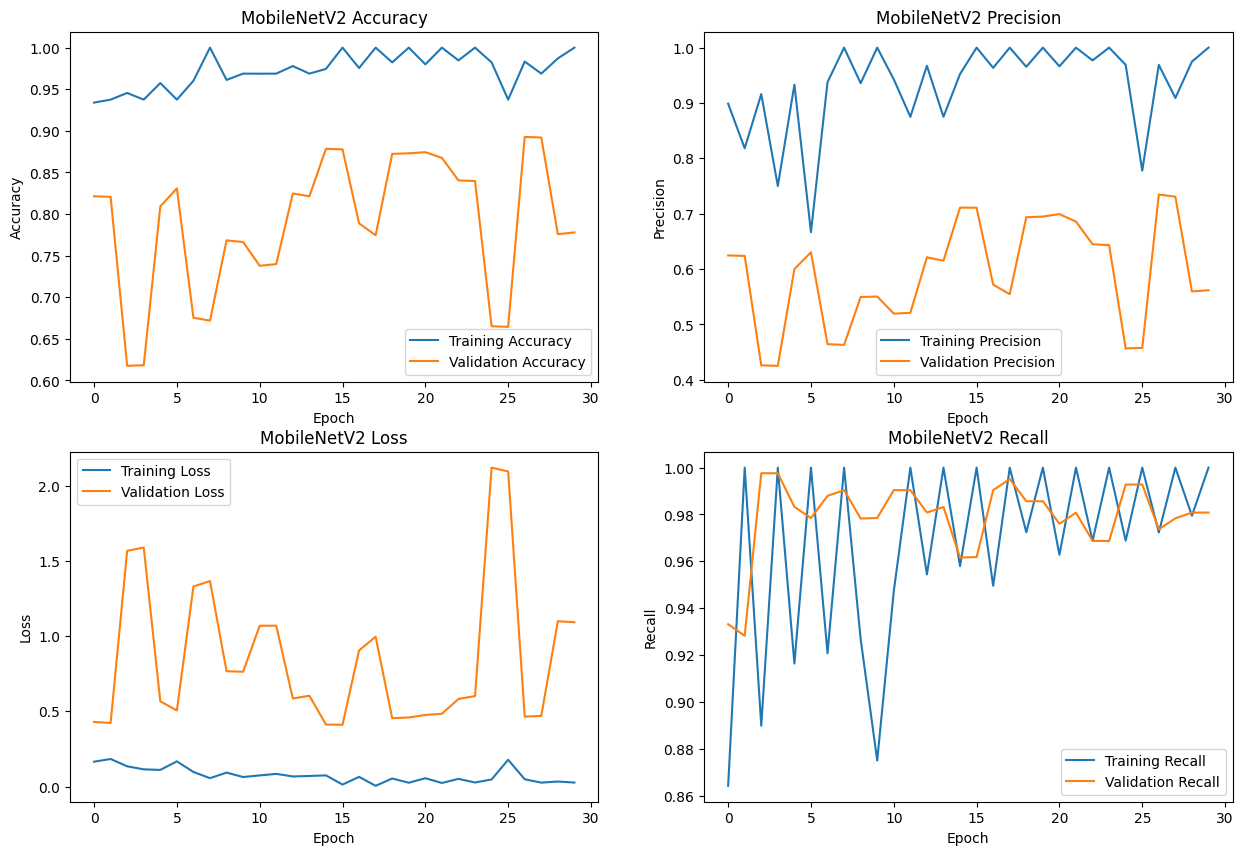

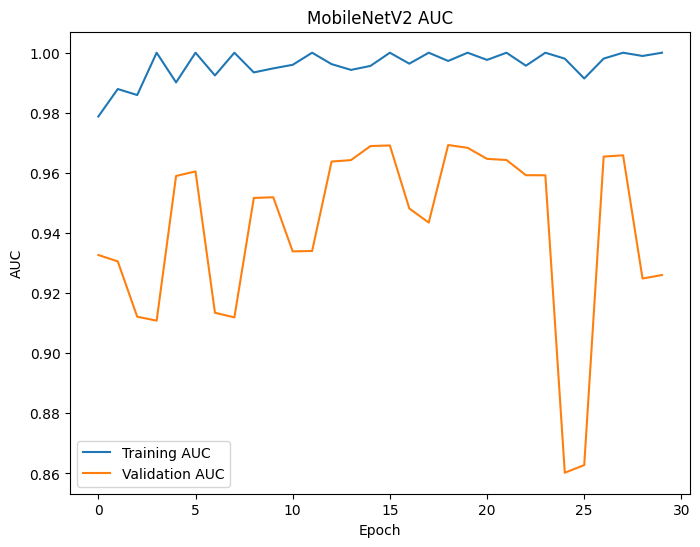

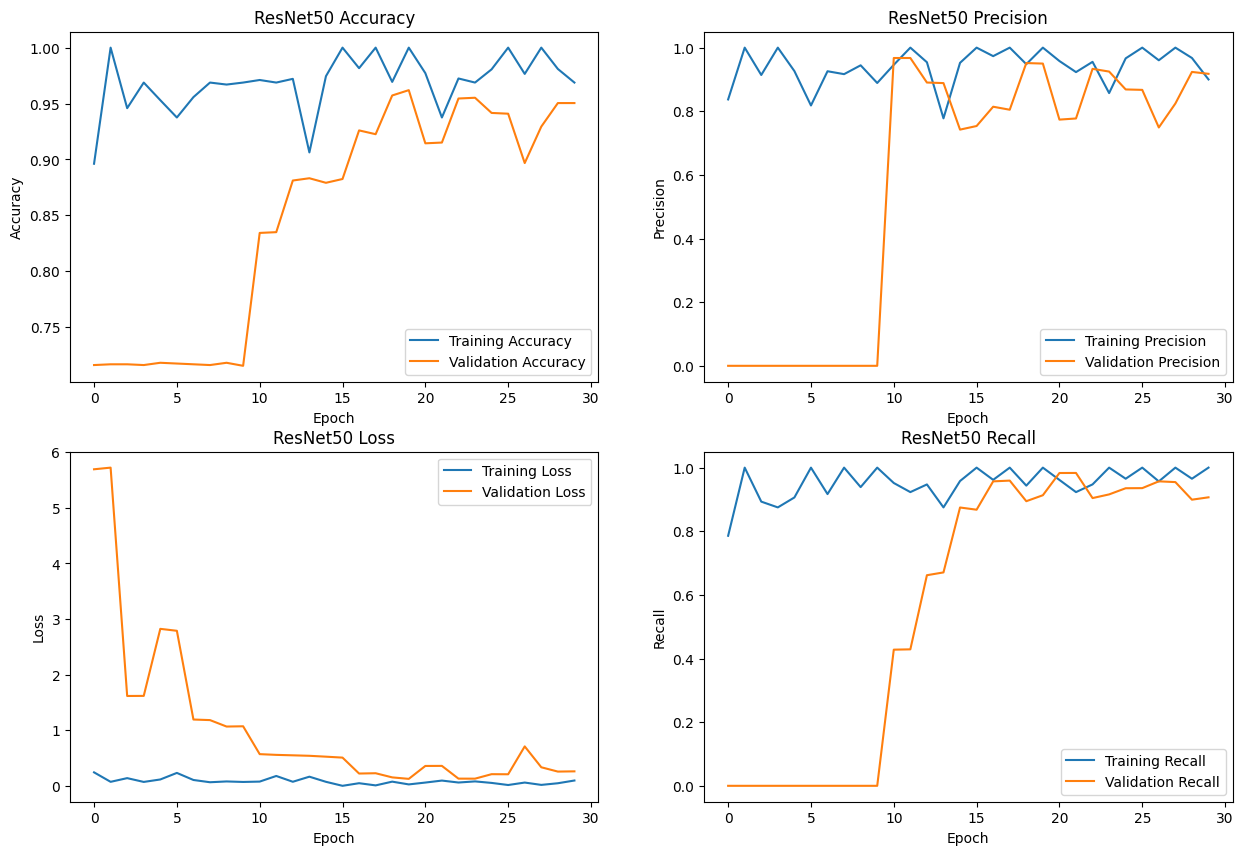

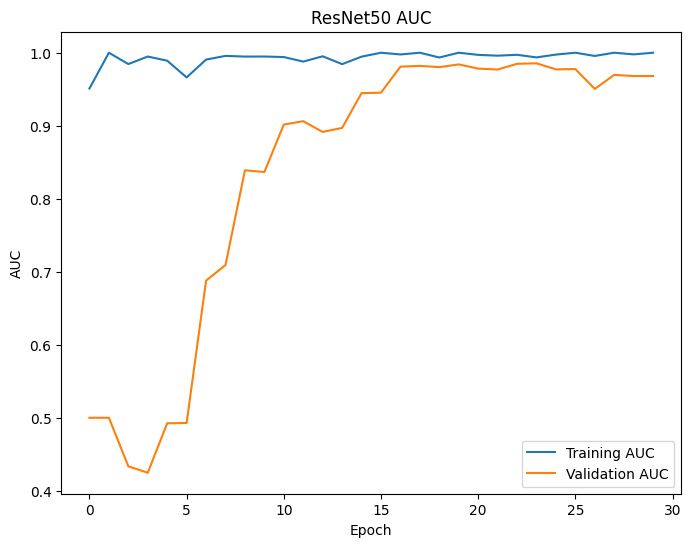

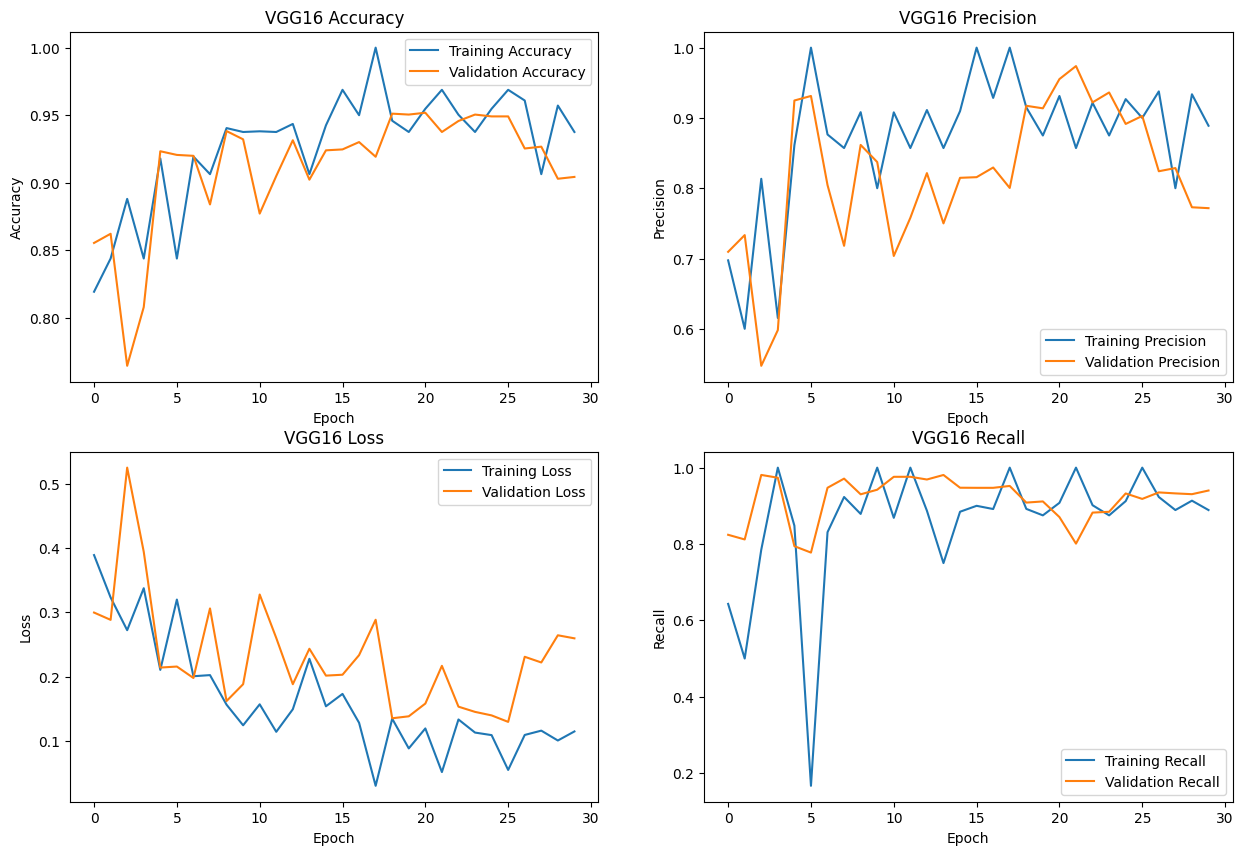

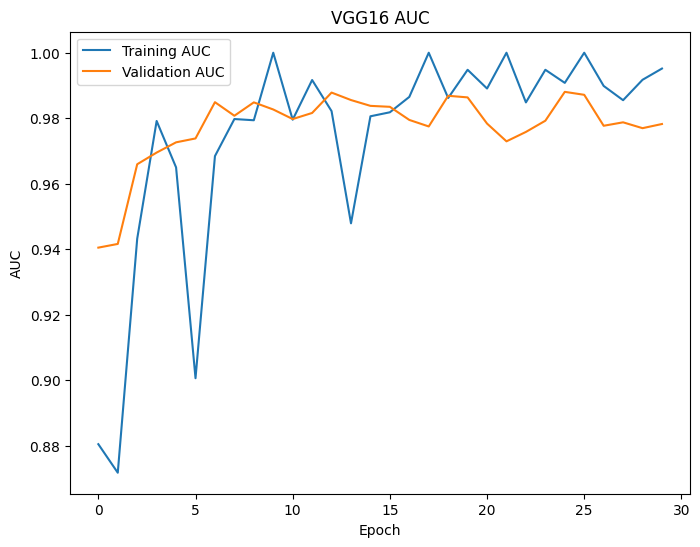

In [37]:
def plot_metrics(history, model_name):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title(f'{model_name} Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()

    axes[0, 1].plot(history.history['Precision'], label='Training Precision')
    axes[0, 1].plot(history.history['val_Precision'], label='Validation Precision')
    axes[0, 1].set_title(f'{model_name} Precision')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].legend()

    axes[1, 0].plot(history.history['loss'], label='Training Loss')
    axes[1, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[1, 0].set_title(f'{model_name} Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()

    axes[1, 1].plot(history.history['Recall'], label='Training Recall')
    axes[1, 1].plot(history.history['val_Recall'], label='Validation Recall')
    axes[1, 1].set_title(f'{model_name} Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()

    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(history.history['AUC'], label='Training AUC')
    plt.plot(history.history['val_AUC'], label='Validation AUC')
    plt.title(f'{model_name} AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()


plot_metrics(history_mobilenet, 'MobileNetV2')
plot_metrics(history_resnet, 'ResNet50')
plot_metrics(history_vgg16, 'VGG16')

In [42]:
input_shape = mobilenet_model.input.shape[1:] # (224, 224, 3)
input_layer = Input(shape=input_shape)

mobilenet_out = mobilenet_model(input_layer) # Output layer of MobileNetV2
resnet_out = resnet_model(input_layer)       # Output layer of ResNet50
vgg16_out = vgg16_model(input_layer)         # Output layer of VGG16

ensemble_output = Average()([mobilenet_out, resnet_out, vgg16_out]) # average of the 3 models, this is known as a 'soft' ensemble. 

# this is different from a 'hard' ensemble where we take the majority vote of the 3 models. and is more common in classification tasks.
# another reason is we can't do a hard ensemble here because we are dealing with probabilities due to the binary nature of dataset
# and taking the majority vote of probabilities doesn't make sense.

ensemble_model = Model(inputs=input_layer, outputs=ensemble_output) 

In [48]:
# this is done for saving the model's weights and architecture for future use. the directory produced can be used to export models in different formats like onnx, tensorflow, etc.
ensemble_model.export("ensemble_model_saved") 

Saved artifact at 'ensemble_model_saved'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_9')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137739523126096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137739457200976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137739457204432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137739457202896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137739048847120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137733550419088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137733550420624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137733550423696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137733550420816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137733550423888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137733550

In [49]:
!python -m tf2onnx.convert --saved-model ensemble_model_saved --output ensemble_model.onnx

E0000 00:00:1738338161.962463   34033 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738338161.970720   34033 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
<frozen runpy>:128: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
2025-01-31 15:42:46,933 - WARNING - ***IMPORTANT*** Installed protobuf is not cpp accelerated. Conversion will be extremely slow. See https://github.com/onnx/tensorflow-onnx/issues/1557
I0000 00:00:1738338167.360202   34033 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 673 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
2025-01-31 15:42:47,361 - WARNING - '--tag' 

In [62]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(true_labels, y_pred_ensemble)
precision = precision_score(true_labels, y_pred_ensemble)
recall = recall_score(true_labels, y_pred_ensemble)
f1 = f1_score(true_labels, y_pred_ensemble)
auc = roc_auc_score(true_labels, ensemble_predictions)

print(f"Ensemble Accuracy: {accuracy}")
print(f"Ensemble Precision: {precision}")
print(f"Ensemble Recall: {recall}")
print(f"Ensemble F1-score: {f1}")
print(f"Ensemble AUC: {auc}")

Ensemble Accuracy: 0.9395161290322581
Ensemble Precision: 0.84472049689441
Ensemble Recall: 0.9645390070921985
Ensemble F1-score: 0.9006622516556292
Ensemble AUC: 0.9908500649285786
